In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import wrds
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
from scipy import stats

Connect to WRDS

In [2]:
conn=wrds.Connection()

Loading library list...
Done


Compustat data

In [3]:
comp = conn.raw_sql("""
                    SELECT
                        f.gvkey,
                        f.datadate,
                        c.sic,
                        f.exchg,
                        -- Required Fundamental Variables 
                        f.at,                             -- Total Assets
                        f.sale,                           -- Sales Revenue
                        f.ib,                             -- Income Before Extraordinary Items
                        f.csho,                           -- Common Shares Outstanding
                        -- Balance Sheet Items
                        f.act,                            -- Current Assets
                        f.che,                            -- Cash and Short-Term Investments
                        f.rect,                           -- Receivables
                        f.ppent,                          -- Property, Plant, and Equipment (Net)
                        f.ivao,                           -- Investments and Advances (Other)
                        f.invt,                           -- Inventories
                        f.ivst,                           -- Short-Term Investments
                        f.intan,                          -- Intangible Assets
                        f.ap,                             -- Accounts Payable
                        f.dlc,                            -- Debt in Current Liabilities
                        f.txp,                            -- Income Taxes Payable
                        f.lct,                            -- Total Current Liabilities
                        f.dltt,                           -- Long-Term Debt
                        f.lt,                             -- Total Liabilities
                        f.ceq,                            -- Common Equity
                        -- Income Statement Items
                        f.cogs,                           -- Cost of Goods Sold
                        f.xsga,                           -- Selling, General, and Administrative Expenses
                        f.xad,                            -- Advertising Expense
                        f.xrd,                            -- Research and Development Expense
                        f.xido,                           -- Extraordinary items and discontinued operations 
                        f.dp,                             -- Depreciation and Amortization
                        f.xint,                           -- Interest and Related Expense
                        f.nopio,                          -- Non-operating income (expense) - other
                        f.txt,                            -- Income Taxes
                        f.spi,                            -- Special Items
                        f.dvc,                            -- Dividend payment
                        f.dvpsx_f,                        -- Common dividends per share
                        -- Cash Flow Statement Items
                        f.oancf,                          -- Operating Cash Flow
                        -- Fama-French Variables
                        f.seq,                            -- Shareholders' Equity
                        f.pstkl,                          -- Preferred Stock Liquidating Value
                        f.txditc,                         -- Deferred Taxes and Investment Tax Credit
                        f.pstkrv,                         -- Preferred Stock Redemption Value
                        f.pstk                            -- Preferred Stock
                    FROM
                        comp.funda f
                    JOIN
                        comp.company c ON f.gvkey = c.gvkey
                    WHERE
                        f.indfmt = 'INDL'                 -- Industrial Format
                        AND f.datafmt = 'STD'             -- Standard Format
                        AND f.popsrc = 'D'                -- Domestic data
                        AND f.consol = 'C'                -- Consolidated
                        AND f.datadate >= '1959-01-01'
                    """, date_cols=['datadate'])

comp['year']=comp['datadate'].dt.year

Create Preferred Stock

In [4]:
comp['ps']=np.where(comp['pstkrv'].isnull(), comp['pstkl'], comp['pstkrv'])
comp['ps']=np.where(comp['ps'].isnull(),comp['pstk'], comp['ps'])
comp['ps']=np.where(comp['ps'].isnull(),0,comp['ps'])
comp['txditc']=comp['txditc'].fillna(0)

Create Book Equity

In [5]:
comp['be']=comp['seq']+comp['txditc']-comp['ps']
comp['be']=np.where(comp['be']>0, comp['be'], np.nan)

Number of years in Compustat

In [6]:
comp=comp.sort_values(by=['gvkey','datadate'])
comp['count']=comp.groupby(['gvkey']).cumcount()
comp=comp[['gvkey','datadate','year','be','count']]

CRSP data

In [7]:
crsp_m = conn.raw_sql("""
                      -- Select relevant stock market data from CRSP monthly stock file 
                      select a.permno,  -- Unique security identifier (PERMNO)
                             a.permco,  -- Unique company identifier (PERMCO)
                             a.date,    -- Trading date
                             b.shrcd,   -- Share code (identifies common vs. preferred stock)
                             b.exchcd,  -- Exchange code (NYSE=1, AMEX=2, NASDAQ=3)
                             a.ret,     -- Monthly total return, including dividends
                             a.retx,    -- Monthly return excluding dividends
                             a.shrout,  -- Number of shares outstanding (in thousands)
                             a.prc      -- Price of the stock (negative for bid/ask averages)
                      from crsp.msf as a
                      
                      -- Join with CRSP monthly security names table (msenames)
                      left join crsp.msenames as b
                      on a.permno = b.permno   -- Match securities by PERMNO
                      and b.namedt <= a.date   -- Ensure the stock name record is active 
                      and a.date <= b.nameendt -- at the time of the stock data record
                      
                      -- Filter for the date range from January 1, 1959, to December 31, 2023
                      where a.date between '01/01/1959' and '12/31/2023'
                      
                      -- Filter for stocks listed on NYSE (1), AMEX (2), or NASDAQ (3)
                      and b.exchcd between 1 and 3
                      """, date_cols=['date']) 

crsp_m[['permco','permno','shrcd','exchcd']]=crsp_m[['permco','permno','shrcd','exchcd']].astype(int)

crsp_m['jdate']=crsp_m['date']+MonthEnd(0)

Add Delisting Return

In [8]:
dlret = conn.raw_sql("""
                     select permno, dlret, dlstdt 
                     from crsp.msedelist
                     """, date_cols=['dlstdt'])

dlret.permno=dlret.permno.astype(int)
dlret['dlstdt']=pd.to_datetime(dlret['dlstdt'])
dlret['jdate']=dlret['dlstdt']+MonthEnd(0)

crsp = pd.merge(crsp_m, dlret, how='left',on=['permno','jdate'])
crsp['dlret']=crsp['dlret'].fillna(0)
crsp['ret']=crsp['ret'].fillna(0)

retadj factors in the delisting returns

In [9]:
crsp['retadj']=(1+crsp['ret'])*(1+crsp['dlret'])-1

Calculate market equity

In [10]:
crsp['me']=crsp['prc'].abs()*crsp['shrout'] 
crsp=crsp.drop(['dlret','dlstdt','prc','shrout'], axis=1)
crsp=crsp.sort_values(by=['jdate','permco','me'])

Aggregate Market Cap

In [11]:
# sum of me across different permno belonging to same permco a given date
crsp_summe = crsp.groupby(['jdate','permco'])['me'].sum().reset_index()

# largest mktcap within a permco/date
crsp_maxme = crsp.groupby(['jdate','permco'])['me'].max().reset_index()

# join by jdate/maxme to find the permno
crsp1=pd.merge(crsp, crsp_maxme, how='inner', on=['jdate','permco','me'])

# drop me column and replace with the sum me
crsp1=crsp1.drop(['me'], axis=1)

# join with sum of me to get the correct market cap info
crsp2=pd.merge(crsp1, crsp_summe, how='inner', on=['jdate','permco'])

# sort by permno and date and also drop duplicates
crsp2=crsp2.sort_values(by=['permno','jdate']).drop_duplicates()

# keep December market cap
crsp2['year']=crsp2['jdate'].dt.year
crsp2['month']=crsp2['jdate'].dt.month
decme=crsp2[crsp2['month']==12]
decme=decme[['permno','date','jdate','me','year']].rename(columns={'me':'dec_me'})

### July to June dates
crsp2['ffdate']=crsp2['jdate']+MonthEnd(-6)
crsp2['ffyear']=crsp2['ffdate'].dt.year
crsp2['ffmonth']=crsp2['ffdate'].dt.month
crsp2['1+retx']=1+crsp2['retx']
crsp2=crsp2.sort_values(by=['permno','date'])

# cumret by stock
crsp2['cumretx']=crsp2.groupby(['permno','ffyear'])['1+retx'].cumprod()

# lag cumret
crsp2['lcumretx']=crsp2.groupby(['permno'])['cumretx'].shift(1)

# lag market cap
crsp2['lme']=crsp2.groupby(['permno'])['me'].shift(1)

# if first permno then use me/(1+retx) to replace the missing value
crsp2['count']=crsp2.groupby(['permno']).cumcount()
crsp2['lme']=np.where(crsp2['count']==0, crsp2['me']/crsp2['1+retx'], crsp2['lme'])

# baseline me
mebase=crsp2[crsp2['ffmonth']==1][['permno','ffyear', 'lme']].rename(columns={'lme':'mebase'})

# merge result back together
crsp3=pd.merge(crsp2, mebase, how='left', on=['permno','ffyear'])
crsp3['wt']=np.where(crsp3['ffmonth']==1, crsp3['lme'], crsp3['mebase']*crsp3['lcumretx'])

decme['year']=decme['year']+1
decme=decme[['permno','year','dec_me']]

# Info as of June
crsp3_jun = crsp3[crsp3['month']==6]

crsp_jun = pd.merge(crsp3_jun, decme, how='inner', on=['permno','year'])
crsp_jun=crsp_jun[['permno','date', 'jdate', 'shrcd','exchcd','retadj','me','wt','cumretx','mebase','lme','dec_me']]
crsp_jun=crsp_jun.sort_values(by=['permno','jdate']).drop_duplicates()

Linking Information

In [12]:
ccm = conn.raw_sql("""
                  -- Select relevant linking information from the CRSP-Compustat link table
                  select gvkey,           -- Compustat's unique company identifier (GVKEY)
                         lpermno as permno, -- CRSP's unique security identifier (PERMNO)
                         linktype,         -- Type of link between CRSP and Compustat
                         linkprim,         -- Primary status of the link (C = primary, P = secondary)
                         linkdt,           -- Start date of the link validity
                         linkenddt         -- End date of the link validity (NULL if still valid)
                  from crsp.ccmxpf_linktable -- CRSP-Compustat link table (monthly updates)
                  
                  -- Filter to include only links that start with 'L' (indicating a reliable link)
                  where substr(linktype,1,1) = 'L'
                  
                  -- Include only primary (C) and primary-plus-secondary (P) links
                  and (linkprim = 'C' or linkprim = 'P')
                  """, date_cols=['linkdt', 'linkenddt'])

# if linkenddt is missing then set to today date
ccm['linkenddt']=ccm['linkenddt'].fillna(pd.to_datetime('today'))

ccm1=pd.merge(comp[['gvkey','datadate','be', 'count']],ccm,how='left',on=['gvkey'])
ccm1['yearend']=ccm1['datadate']+YearEnd(0)
ccm1['jdate']=ccm1['yearend']+MonthEnd(6)

In [13]:
# set link date bounds
ccm2=ccm1[(ccm1['jdate']>=ccm1['linkdt'])&(ccm1['jdate']<=ccm1['linkenddt'])]
ccm2=ccm2[['gvkey','permno','datadate','yearend', 'jdate','be', 'count']]

# link comp and crsp
ccm_jun=pd.merge(crsp_jun, ccm2, how='inner', on=['permno', 'jdate'])
ccm_jun['beme']=ccm_jun['be']*1000/ccm_jun['dec_me']

Bucket Breakdown

In [14]:
# select NYSE stocks for bucket breakdown
# exchcd = 1 and positive beme and positive me and shrcd in (10,11) and at least 2 years in comp
nyse=ccm_jun[(ccm_jun['exchcd']==1) & (ccm_jun['beme']>0) & (ccm_jun['me']>0) & \
             (ccm_jun['count']>=1) & ((ccm_jun['shrcd']==10) | (ccm_jun['shrcd']==11))]

# size breakdown
nyse_sz=nyse.groupby(['jdate'])['me'].median().to_frame().reset_index().rename(columns={'me':'sizemedn'})

# beme breakdown
nyse_bm=nyse.groupby(['jdate'])['beme'].describe(percentiles=[0.3, 0.7]).reset_index()
nyse_bm=nyse_bm[['jdate','30%','70%']].rename(columns={'30%':'bm30', '70%':'bm70'})

nyse_breaks = pd.merge(nyse_sz, nyse_bm, how='inner', on=['jdate'])

# join back size and beme breakdown
ccm1_jun = pd.merge(ccm_jun, nyse_breaks, how='left', on=['jdate'])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [15]:
# function to assign sz and bm bucket
def sz_bucket(row):
    if row['me']==np.nan:
        value=''
    elif row['me']<=row['sizemedn']:
        value='S'
    else:
        value='B'
    return value

def bm_bucket(row):
    if 0<=row['beme']<=row['bm30']:
        value = 'L'
    elif row['beme']<=row['bm70']:
        value='M'
    elif row['beme']>row['bm70']:
        value='H'
    else:
        value=''
    return value

In [16]:
# assign size portfolio
ccm1_jun['szport']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count']>=1), ccm1_jun.apply(sz_bucket, axis=1), '')

# assign book-to-market portfolio
ccm1_jun['bmport']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count']>=1), ccm1_jun.apply(bm_bucket, axis=1), '')

# create positivebmeme and nonmissport variable
ccm1_jun['posbm']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count']>=1), 1, 0)
ccm1_jun['nonmissport']=np.where((ccm1_jun['bmport']!=''), 1, 0)

In [17]:
# store portfolio assignment as of June
june=ccm1_jun[['permno','date', 'jdate', 'bmport','szport','posbm','nonmissport']]
june['ffyear']=june['jdate'].dt.year

# merge back with monthly records
crsp3 = crsp3[['date','permno','shrcd','exchcd','retadj','me','wt','cumretx','ffyear','jdate']]
ccm3=pd.merge(crsp3, 
        june[['permno','ffyear','szport','bmport','posbm','nonmissport']], how='left', on=['permno','ffyear'])

# keeping only records that meet the criteria
ccm4=ccm3[(ccm3['wt']>0)& (ccm3['posbm']==1) & (ccm3['nonmissport']==1) & 
          ((ccm3['shrcd']==10) | (ccm3['shrcd']==11))]

/var/folders/zv/y4lfwq1s277d8l9hk50_nyc40000gn/T/ipykernel_13392/2324879243.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  june['ffyear']=june['jdate'].dt.year


Form Fama French Factors

In [18]:
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

In [19]:
# value-weigthed return
vwret=ccm4.groupby(['jdate','szport','bmport']).apply(wavg, 'retadj','wt').to_frame().reset_index().rename(columns={0: 'vwret'})
vwret['sbport']=vwret['szport']+vwret['bmport']

# firm count
vwret_n=ccm4.groupby(['jdate','szport','bmport'])['retadj'].count().reset_index().rename(columns={'retadj':'n_firms'})
vwret_n['sbport']=vwret_n['szport']+vwret_n['bmport']

# tranpose
ff_factors=vwret.pivot(index='jdate', columns='sbport', values='vwret').reset_index()
ff_nfirms=vwret_n.pivot(index='jdate', columns='sbport', values='n_firms').reset_index()

/var/folders/zv/y4lfwq1s277d8l9hk50_nyc40000gn/T/ipykernel_13392/3555273468.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vwret=ccm4.groupby(['jdate','szport','bmport']).apply(wavg, 'retadj','wt').to_frame().reset_index().rename(columns={0: 'vwret'})


In [20]:
# create SMB and HML factors
ff_factors['WH']=(ff_factors['BH']+ff_factors['SH'])/2
ff_factors['WL']=(ff_factors['BL']+ff_factors['SL'])/2
ff_factors['WHML'] = ff_factors['WH']-ff_factors['WL']

ff_factors['WB']=(ff_factors['BL']+ff_factors['BM']+ff_factors['BH'])/3
ff_factors['WS']=(ff_factors['SL']+ff_factors['SM']+ff_factors['SH'])/3
ff_factors['WSMB'] = ff_factors['WS']-ff_factors['WB']
ff_factors=ff_factors.rename(columns={'jdate':'date'})

# n firm count
ff_nfirms['H']=ff_nfirms['SH']+ff_nfirms['BH']
ff_nfirms['L']=ff_nfirms['SL']+ff_nfirms['BL']
ff_nfirms['HML']=ff_nfirms['H']+ff_nfirms['L']

ff_nfirms['B']=ff_nfirms['BL']+ff_nfirms['BM']+ff_nfirms['BH']
ff_nfirms['S']=ff_nfirms['SL']+ff_nfirms['SM']+ff_nfirms['SH']
ff_nfirms['SMB']=ff_nfirms['B']+ff_nfirms['S']
ff_nfirms['TOTAL']=ff_nfirms['SMB']
ff_nfirms=ff_nfirms.rename(columns={'jdate':'date'})

Compare with Fama French 

In [21]:
_ff = conn.get_table(library='ff', table='factors_monthly')
_ff=_ff[['date','smb','hml']]
_ff['date'] = pd.to_datetime(_ff['date']) + MonthEnd(0)
ff_factors['date'] = pd.to_datetime(ff_factors['date'])

_ffcomp = pd.merge(_ff, ff_factors[['date', 'WSMB', 'WHML']], how='inner', on='date')

columns_to_convert = ['smb', 'hml']
def convert_to_float(df, columns):
    for col in columns:
        if df[col].dtype == 'object':
            df[col] = df[col].apply(lambda x: float(x) if pd.notnull(x) else x)
    return df
_ffcomp = convert_to_float(_ffcomp, columns_to_convert)

_ffcomp70=_ffcomp[_ffcomp['date']>='01/01/1970']

numeric_columns = ['smb', 'WSMB', 'hml', 'WHML']
_ffcomp70[numeric_columns] = _ffcomp70[numeric_columns].astype(float)
smb_corr, smb_p = stats.pearsonr(_ffcomp70['smb'], _ffcomp70['WSMB'])
hml_corr, hml_p = stats.pearsonr(_ffcomp70['hml'], _ffcomp70['WHML'])
print(f"Pearson correlation between SMB and WSMB: {smb_corr} (p-value: {smb_p})")
print(f"Pearson correlation between HML and WHML: {hml_corr} (p-value: {hml_p})")

Pearson correlation between SMB and WSMB: 0.9957538697698897 (p-value: 0.0)
Pearson correlation between HML and WHML: 0.9834843262225355 (p-value: 0.0)


/var/folders/zv/y4lfwq1s277d8l9hk50_nyc40000gn/T/ipykernel_13392/3858684273.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _ffcomp70[numeric_columns] = _ffcomp70[numeric_columns].astype(float)


In [22]:
_ffcomp.head()

,date,smb,hml,WSMB,WHML
0,1961-07-31,-0.0190,-0.0009,NaN,NaN
1,1961-08-31,-0.0175,-0.0028,NaN,NaN
2,1961-09-30,-0.0107,-0.0061,NaN,NaN
3,1961-10-31,-0.0165,0.0015,NaN,NaN
4,1961-11-30,0.0126,-0.0123,NaN,NaN


In [23]:
_ffcomp.dtypes

date    datetime64[ns]
smb            float64
hml            float64
WSMB           float64
WHML           float64
dtype: object

In [24]:
_ffcomp.tail()

,date,smb,hml,WSMB,WHML
745,2023-08-31,-0.0320,-0.0108,-0.037304,-0.004103
746,2023-09-30,-0.0249,0.0145,-0.025190,0.014056
747,2023-10-31,-0.0388,0.0019,-0.044850,0.005359
748,2023-11-30,-0.0003,0.0166,0.002218,-0.000510
749,2023-12-31,0.0636,0.0492,0.073209,0.026395


In [25]:
_ffcomp.date = pd.to_datetime(_ffcomp.date)
_ffcomp.set_index('date', inplace=True)
_ffcomp.head()

,smb,hml,WSMB,WHML
date,,,,
1961-07-31,-0.0190,-0.0009,NaN,NaN
1961-08-31,-0.0175,-0.0028,NaN,NaN
1961-09-30,-0.0107,-0.0061,NaN,NaN
1961-10-31,-0.0165,0.0015,NaN,NaN
1961-11-30,0.0126,-0.0123,NaN,NaN


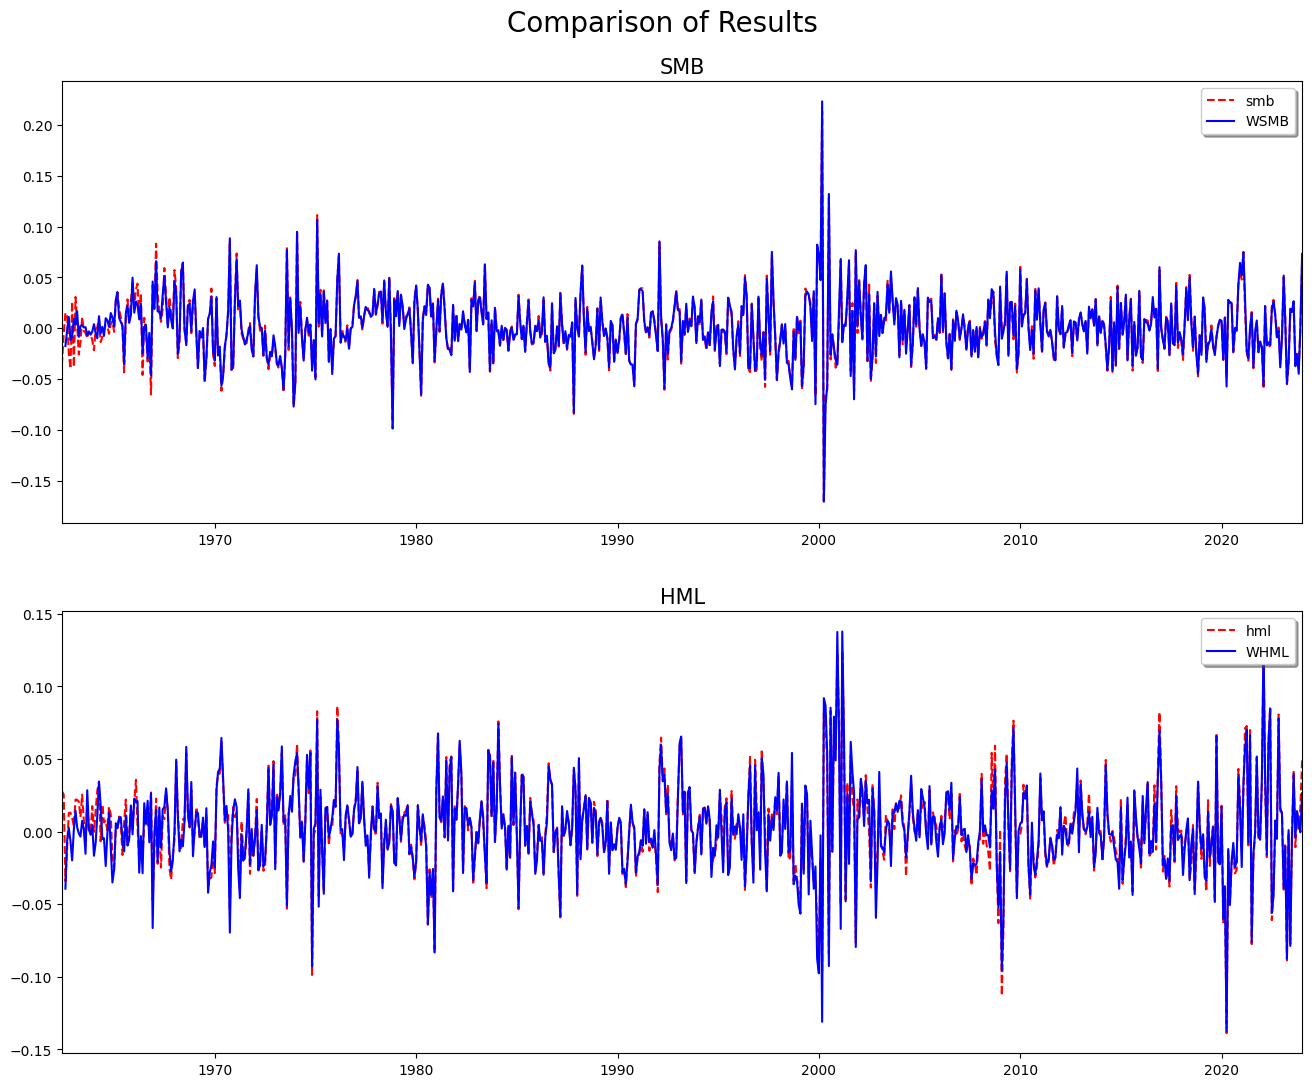

In [26]:
plt.figure(figsize=(16,12))
plt.suptitle('Comparison of Results', fontsize=20)

ax1 = plt.subplot(211)
ax1.set_title('SMB', fontsize=15)
ax1.set_xlim([dt.datetime(1962,6,1), dt.datetime(2023,12,31)])
ax1.plot(_ffcomp['smb'], 'r--', _ffcomp['WSMB'], 'b-')
ax1.legend(('smb','WSMB'), loc='upper right', shadow=True)

ax2 = plt.subplot(212)
ax2.set_title('HML', fontsize=15)
ax2.plot(_ffcomp['hml'], 'r--', _ffcomp['WHML'], 'b-')
ax2.set_xlim([dt.datetime(1962,6,1), dt.datetime(2023,12,31)])
ax2.legend(('hml','WHML'), loc='upper right', shadow=True)

plt.subplots_adjust(top=0.92, hspace=0.2)

plt.show()